<a href="https://colab.research.google.com/github/Dinith-Thejana/Assignment_2B/blob/main/GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploads = files.upload()

Saving cleaned_data.csv to cleaned_data.csv


In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('/content/cleaned_data.csv')
df.head(20)

,SCATS Number,Location,Date,Interval,Volume,Time
0,2200,UNION_RD N of MAROONDAH_HWY,2006-10-01,V00,25,00:00
1,2200,UNION_RD N of MAROONDAH_HWY,2006-10-02,V00,4,00:00
2,2200,UNION_RD N of MAROONDAH_HWY,2006-10-03,V00,7,00:00
3,2200,UNION_RD N of MAROONDAH_HWY,2006-10-04,V00,3,00:00
4,2200,UNION_RD N of MAROONDAH_HWY,2006-10-05,V00,8,00:00
5,2200,UNION_RD N of MAROONDAH_HWY,2006-10-06,V00,8,00:00
6,2200,UNION_RD N of MAROONDAH_HWY,2006-10-07,V00,17,00:00
7,2200,UNION_RD N of MAROONDAH_HWY,2006-10-08,V00,39,00:00
8,2200,UNION_RD N of MAROONDAH_HWY,2006-10-09,V00,2,00:00
9,2200,UNION_RD N of MAROONDAH_HWY,2006-10-10,V00,5,00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

In [5]:
# Load the cleaned dataset
df = pd.read_csv('/content/cleaned_data.csv')

# Convert Date to datetime format to operate time series
df['Date'] = pd.to_datetime(df['Date'])

# Group by Date and collect the volume for each day
daily_volume = df.groupby('Date')['Volume'].sum().reset_index()

# Normalize volume using MinMaxScaler(between 0 and 1)
scaler = MinMaxScaler()
daily_volume['Volume_scaled'] = scaler.fit_transform(daily_volume[['Volume']])

# Create sequences of past seq_len days as input and the next day's volume as the target
def create_sequences(data, seq_len):
    xs, ys = [], []
    for i in range(len(data) - seq_len):
        x = data[i:(i + seq_len)]
        y = data[i + seq_len]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 5  # set the sequence length

# create X(INPUT) and y (OUTPUT) from the scaled volume data
X, y = create_sequences(daily_volume['Volume_scaled'].values, sequence_length)

# Reshape X to fit GRU input(samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split the dataset into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [6]:
# building the GRU model
model = Sequential()
model.add(GRU(64, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,929 (50.50 KB)

 Trainable params: 12,929 (50.50 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
#Train the GRU model
history = model.fit(X_train, y_train, epochs=50, batch_size=16,
                    validation_data=(X_test, y_test))


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 382ms/step - loss: 0.5710 - val_loss: 0.4551
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.4628 - val_loss: 0.3577
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.3463 - val_loss: 0.2782
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.2727 - val_loss: 0.2157
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.2070 - val_loss: 0.1711
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1609 - val_loss: 0.1439
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1309 - val_loss: 0.1333
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.1211 - val_loss: 0.1361
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1139 - val_loss: 0.1462
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.1189 - val_loss: 0.1536
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1365 - val_loss: 0.1565
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.1111 - val_loss: 0.1553


In [11]:
# Predict and inverse transform
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


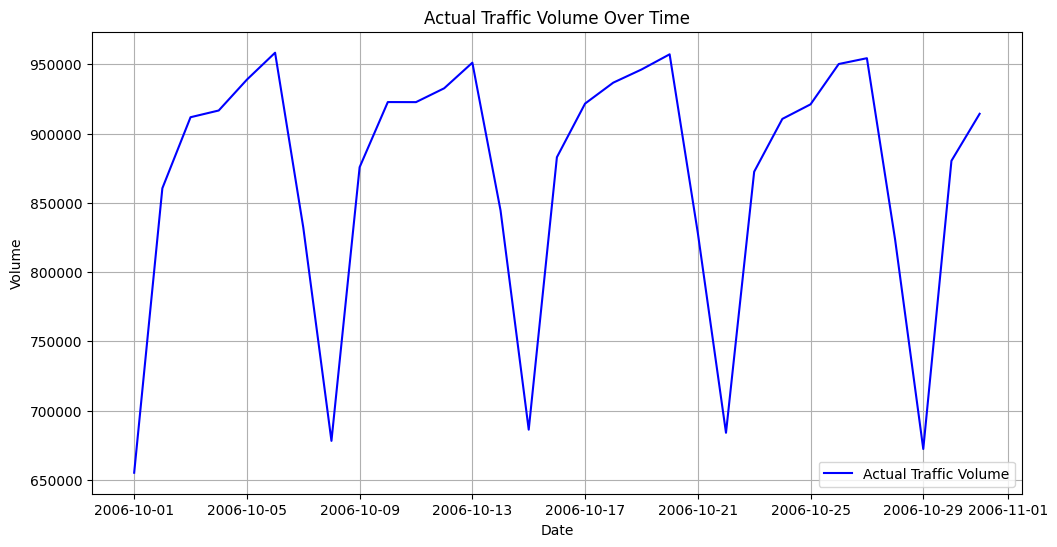

In [12]:
# Plot actual volume
plt.figure(figsize=(12, 6))
plt.plot(daily_volume['Date'], daily_volume['Volume'], label='Actual Traffic Volume', color='blue')
plt.title('Actual Traffic Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


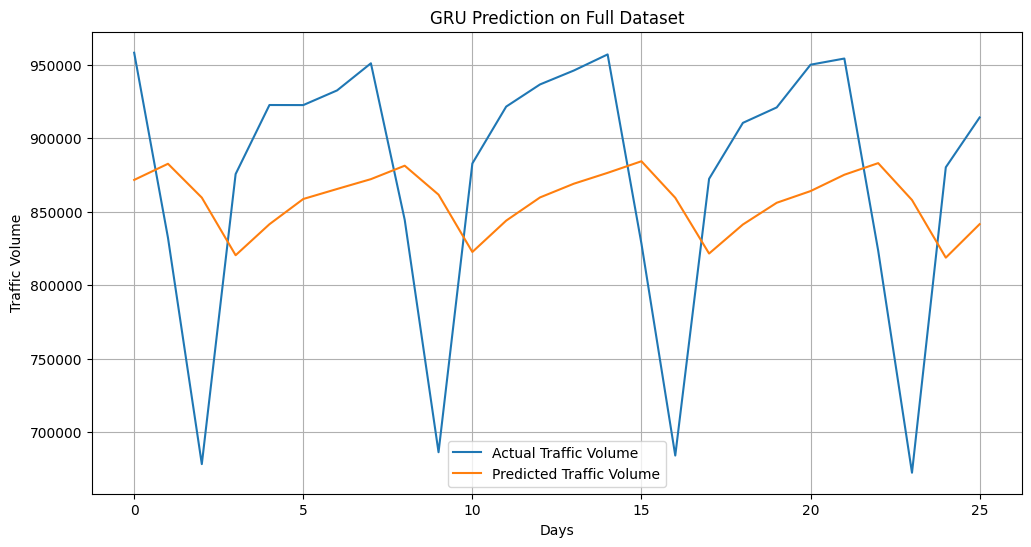

In [13]:
# Create sequences for full prediction
sequence_length = 5
full_data = daily_volume['Volume_scaled'].values

X_full = []
for i in range(len(full_data) - sequence_length):
    X_full.append(full_data[i:i + sequence_length])

X_full = np.array(X_full)
X_full = X_full.reshape((X_full.shape[0], X_full.shape[1], 1))

# Predict
y_full_pred_scaled = model.predict(X_full)
y_full_pred = scaler.inverse_transform(y_full_pred_scaled)

# Prepare actual values (same length as prediction)
y_actual_full = daily_volume['Volume'].values[sequence_length:]

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_actual_full, label='Actual Traffic Volume')
plt.plot(y_full_pred, label='Predicted Traffic Volume')
plt.title("GRU Prediction on Full Dataset")
plt.xlabel("Days")
plt.ylabel("Traffic Volume")
plt.legend()
plt.grid(True)
plt.show()


In [14]:
mse = mean_squared_error(y_test_inv, y_pred_inv)# Calculations
rmse = np.sqrt(mse)# Calculations
# Print the RMSE value rounded to 2 decimal places
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Root Mean Squared Error (RMSE): 100678.83


In [15]:
model.save("gru_traffic_model.h5")
